# 

In [1]:
import math 
import matplotlib.pyplot as plt

In [87]:
class Value:
    def __init__(self, data, _children=(), op=""):
        self.data = data
        self._prev = _children
        self.op = op
        self.grad = 0
        self._backward = lambda: None
        
    def __add__(self, other):
        if not isinstance(other, Value): 
            other = Value(other)
        out = Value(self.data + other.data, (self,other), "+")

        def _backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad

        out._backward = _backward
            
        return out

    def __mul__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad 
            other.grad += self.data * out.grad
            
        out._backward = _backward
        return out

    def __sub__(self, other):
        return self + (other * -1)

    def __truediv__(self, other):
        return self * (other**-1.0)
    
    def __repr__(self):
        return f"Data([{self.data}])"
        
    def __rmul__(self, other):
        return self * other

    def __radd__(self, other):
        return self+other

    def __rtruediv__(self, other):
        return self / other

    def __pow__(self, other):
        assert isinstance(other, float), "Only float valeus are allowed for now"
        out = Value(self.data**other, (self,), f"**{other}")

        def _backward():
            self.grad +=  ((other * self.data)**(other-1)) * out.grad 
        out._backward = _backward
        
        return out

    def exp(self):
        result = math.exp(self.data)
        out = Value(result, (self,), "exp")
        
        def _backward():
            self.grad += result * out.grad

        out._backward = _backward
        
        return out

    def log(self):
        result =  math.log(self.data)
        out = Value(result, (self,), "log")

        def _backward():
            self.grad += (self.data**-1.0) * out.grad 
        out._backward = _backward()

        return out

    def tanh(self):
        e = math.exp((2 * self.data))
        result = (e-1)/(e+1)
        out = Value(result, (self,), "tanh")

        def _backward():
           self.grad += (1-(result**2)) * out.grad
        out._backward = _backward

        return out 

    def relu(self):
        result = max(self.data, 0)
        out = Value(result, (self,), "relu")
        def _backward():
            if(self.data>0):
                print(f"{self.data} greater then 0")
                self.grad += 1.0 *out.grad
            else:
                print("something")
                self.grad += 0
            # self.grad += 1.0 if self.data>0.1 else 0 * out.grad
        out._backward = _backward

        return out
        
    def backward(self):
        topo = []
        visited = set()
        
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

<p>grad is basically 
it represent the rate of change wrt to the the variable in a function
</p>

a = 2

f(x) = x**2 + 4

a.grad = 4

In [3]:
import math
import random

class Neuron:
    def __init__(self, nin):
        self.weights = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.bias = Value(random.uniform(-1,1))

    def __call__(self, inpts):
        out = sum([weight * inpt for weight, inpt in zip(self.weights, inpts)], self.bias)
        out = out.tanh()
        return out 

    def parameters(self):
        out = self.weights + [self.bias]
        return out

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, inpt):
        out = [neuron(inpt) for neuron in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        out = [p for neuron in self.neurons for p in neuron.parameters()]  
        return out

class NLP:
    def __init__(self, nin, layers):
        layers_i = [nin] + layers
        self.layers = [Layer(layers_i[i], layers_i[i+1]) for i in range(len(layers))]

    def __call__(self, inpts): 
        x = inpts
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        out = [p for layer in self.layers for p in layer.parameters()]
        return out
        

In [12]:
inpts = [[3.0,-2.0,1.0], [-1.0, 2.0, -3.0], [-2.0, 1.0, 3.0]]
out = [1,-1,1]

In [13]:
nn = NLP(3, [4, 4, 1])
t_loss = []

for i in range(30):

    for p in nn.parameters():
        p.grad = 0
    
    preds = [nn(inpt) for inpt in inpts]
    loss = sum([(pred-real)**2.0 for real, pred in zip(out, preds)])
    t_loss.append((i,loss))
    
    loss.backward()
    
    # Update parameters
    for p in nn.parameters():
        p.data += (-0.01 * p.grad)

    print(f"iter={i}:loss={loss.data:.6f}")

iter=0:loss=7.371287
iter=1:loss=6.852224
iter=2:loss=6.321487
iter=3:loss=5.794318
iter=4:loss=5.284277
iter=5:loss=4.803178
iter=6:loss=4.361374
iter=7:loss=3.966901
iter=8:loss=3.624162
iter=9:loss=3.333461
iter=10:loss=3.091245
iter=11:loss=2.890810
iter=12:loss=2.723768
iter=13:loss=2.581770
iter=14:loss=2.457665
iter=15:loss=2.345859
iter=16:loss=2.242199
iter=17:loss=2.143696
iter=18:loss=2.048252
iter=19:loss=1.954454
iter=20:loss=1.861419
iter=21:loss=1.768694
iter=22:loss=1.676176
iter=23:loss=1.584056
iter=24:loss=1.492755
iter=25:loss=1.402858
iter=26:loss=1.315044
iter=27:loss=1.230011
iter=28:loss=1.148407
iter=29:loss=1.070779


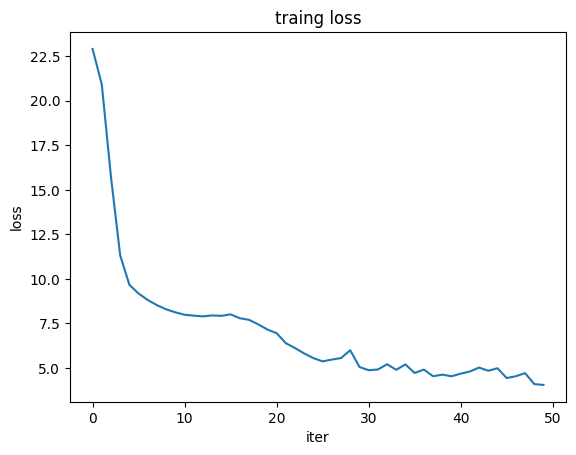

In [26]:
plt.figure()
plt.xlabel("iter")
plt.ylabel("loss")
plt.title("traing loss")

xs = [x[0] for x in t_loss]
ys = [y[1].data for y in t_loss]
plt.plot(xs,ys)
plt.show()

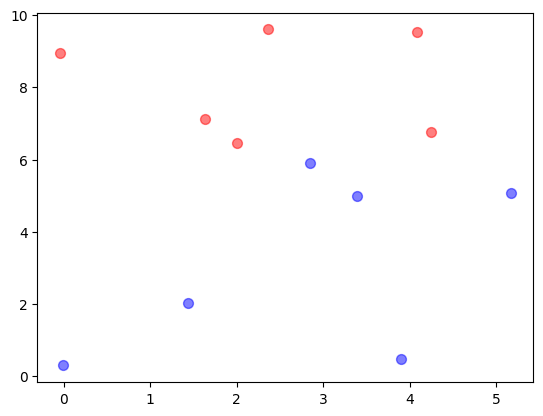

In [20]:
import random
red = [(i+random.uniform(-1, 1), random.uniform(6, 10)) for i in range(6)]
blue = [(i+random.uniform(-1, 1), random.uniform(0, 6)) for i in range(6)]

rxs = [rx[0] for rx in red]
rys =[ry[1] for ry in red]
# cr = [0.1 for _ in range(len(red))]

bxs = [bx[0] for bx in blue]
bys = [yb[1] for yb in blue]
# cb = [0.5 for _ in range(len(blue))]

area = 50
colors = 1

plt.scatter(rxs, rys, s=area, c="red", alpha=0.5)
plt.scatter(bxs, bys, s=area, c="blue", alpha=0.5)
plt.show()

In [21]:
train_data = red + blue
train_label = [1 if i<6 else -1 for i in range(len(train_data))]  
train_label

[1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1]

In [25]:
model = NLP(2, [8, 8, 1]) 
t_loss = []
for i in range(50):
    for p in model.parameters():
        p.grad = 0
        
    preds = [model(i) for i in train_data]
    loss = sum([(pred-true)**2.0 for pred, true in zip(preds, train_label)])
    t_loss.append((i,loss))
    
    loss.backward()
    
    # Update parameters
    for p in model.parameters():
        p.data += (-0.01 * p.grad)

    print(f"iter:{i} - loss:{loss.data}")
    


iter:0 - loss:22.905861549429144
iter:1 - loss:20.917416342008856
iter:2 - loss:15.722849620631724
iter:3 - loss:11.325436348773545
iter:4 - loss:9.671500478581653
iter:5 - loss:9.180026173281986
iter:6 - loss:8.815614328519787
iter:7 - loss:8.5272418787448
iter:8 - loss:8.294259824160086
iter:9 - loss:8.126678245164385
iter:10 - loss:7.989905405460128
iter:11 - loss:7.939973417367018
iter:12 - loss:7.89853401868142
iter:13 - loss:7.95065768434722
iter:14 - loss:7.928786798489438
iter:15 - loss:8.012942185258067
iter:16 - loss:7.794026216024453
iter:17 - loss:7.704256642947775
iter:18 - loss:7.4526299520296995
iter:19 - loss:7.160179307763833
iter:20 - loss:6.956569646842878
iter:21 - loss:6.395296990367615
iter:22 - loss:6.120570853978015
iter:23 - loss:5.818615967977624
iter:24 - loss:5.555096595004507
iter:25 - loss:5.374377494492035
iter:26 - loss:5.474689107882748
iter:27 - loss:5.56070213311185
iter:28 - loss:5.998413251928548
iter:29 - loss:5.062462787142868
iter:30 - loss:4.878

In [28]:
preds

[Data([0.7746998495370948]),
 Data([0.7529210644821204]),
 Data([0.7728240196033034]),
 Data([0.702745598507801]),
 Data([0.6776637865500454]),
 Data([-0.19120848724797038]),
 Data([-0.8163578561279394]),
 Data([-0.7063241183744737]),
 Data([0.3775143907224729]),
 Data([-0.5016310566042388]),
 Data([-0.9323233908754163]),
 Data([-0.912430729608913])]

In [48]:
arr.append([1, 1*0.4])
arr

[[0, 0.0], [1, 0.4]]

In [51]:
arr

[[0, 0.0], [1, 0.4]]

In [60]:
arr[0][0:1]

[0]

In [68]:
import numpy as np
arr = [[np.random.rand()*i, i] for i in np.arange(0,10)]

In [74]:
arr

[[0.0, 0],
 [0.13781108290777655, 1],
 [0.03844029865012688, 2],
 [1.1331768038783232, 3],
 [3.22117499177825, 4],
 [3.494633376257712, 5],
 [5.890108573428346, 6],
 [3.563849959749021, 7],
 [1.8188240152123472, 8],
 [1.833700413843646, 9]]

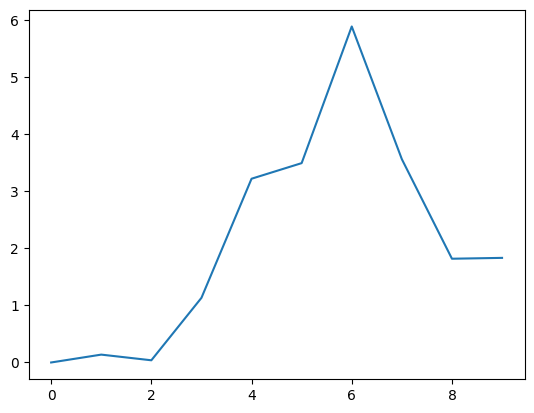

In [80]:
t_arr = list(zip(*arr))
plt.plot(t_arr[1],t_arr[0])